# Descripción

La compañía de seguros quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [ ]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'INSTALLER'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
import math
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [ ]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [ ]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [ ]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4427,1,48.0,14100.0,1,1
1449,1,21.0,45800.0,1,0
3280,0,34.0,41500.0,1,0
3236,1,37.0,23700.0,1,0
3889,1,20.0,46600.0,3,0
4271,0,20.0,35700.0,1,0
1216,0,27.0,41800.0,1,0
842,0,20.0,45000.0,1,0
4925,1,44.0,32000.0,1,1
4615,1,28.0,16300.0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [ ]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:}
df['age'] = df['age'].astype('int64')

In [ ]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [ ]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

In [ ]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


- Como podemos observar todas las estadisticas se encuentran en valores normales, no se observan valores atipicos con este analisis.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

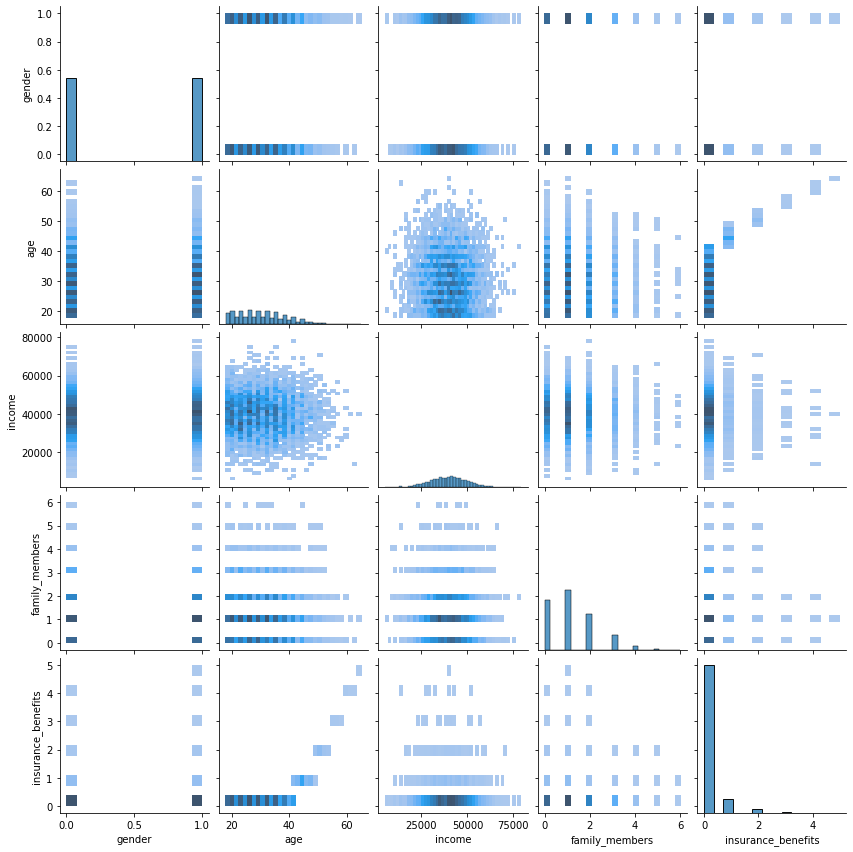

In [ ]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

In [ ]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [ ]:
def get_knn(df, n, k, metric):

    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar
    :param n: número de objetos para los que se buscan los vecinos más cercanos
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)

    df_res = pd.concat([
        df.iloc[nbrs_indices[0]],
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)

    return df_res

Escalar datos.

In [ ]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [ ]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
82,0.0,0.476923,0.473418,0.333333,0
1347,0.0,0.292308,0.392405,0.333333,0
321,0.0,0.353846,0.445570,0.166667,0
1746,0.0,0.723077,0.540506,0.000000,1
2198,0.0,0.323077,0.511392,0.500000,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [ ]:
# Df no escalado con euclidiano
knn_result = get_knn(df, n=0, k=5, metric='euclidean')
print(knn_result)

      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051
4031       1   44  49600.0               2                   1  3.162278
3424       0   38  49600.0               0                   0  3.316625


In [ ]:
# Df no escalado con manhattan
knn_result = get_knn(df, n=0, k=5, metric='manhattan')
print(knn_result)

      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
2022       1   41  49600.0               0                   0       1.0
1225       0   42  49600.0               0                   1       3.0
4031       1   44  49600.0               2                   1       4.0
3424       0   38  49600.0               0                   0       5.0


In [ ]:
# Df escalado con eucilidano
knn_result = get_knn(df_scaled, n=0, k=5, metric='euclidean')
print(knn_result)

      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754
4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
3275     1.0  0.646154  0.651899        0.166667                   1  0.028550


In [ ]:
# Df escalado con manhattan
knn_result = get_knn(df_scaled, n=0, k=5, metric='manhattan')
print(knn_result)

      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245
4869     1.0  0.646154  0.637975        0.166667                   1  0.025511
3365     1.0  0.630769  0.596203        0.166667                   0  0.031646


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?**

La razón principal es que las diferencias de escala entre las características pueden llevar a que ciertas características dominen la medida de distancia en detrimento de otras. Esto puede afectar la capacidad del algoritmo para encontrar correctamente los vecinos más cercanos.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?**

La diferencia principal entre ambas métricas radica en cómo se mide la distancia. La métrica de distancia Manhattan tiende a ser más adecuada cuando las características tienen diferentes escalas o cuando se desea enfatizar la diferencia en valores absolutos entre las características. Por otro lado, la métrica de distancia euclidiana es más adecuada cuando se desea considerar la relación de magnitud y dirección entre las características.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

In [ ]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [ ]:
# comprueba el desequilibrio de clases con value_counts()
class_counts = df['insurance_benefits_received'].value_counts()
print(class_counts)

0    4436
1     564
Name: insurance_benefits_received, dtype: int64


In [ ]:
def eval_classifier(y_true, y_pred):
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')

# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [ ]:
# generar la salida de un modelo aleatorio
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [ ]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))

    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)

    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [ ]:
def evaluate_knn(X_train, y_train, X_test, y_test, k):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_scaled = knn.predict(X_test_scaled)
    f1_scaled = sklearn.metrics.f1_score(y_test, y_pred_scaled)

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1 = sklearn.metrics.f1_score(y_test, y_pred)

    print(f'K = {k}')
    print(f'F1 (escalado): {f1_scaled:.2f}')
    print(f'F1 (no escalado): {f1:.2f}')
    print()

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

for k in range(1, 11):
    evaluate_knn(X_train, y_train, X_test, y_test, k)

K = 1
F1 (escalado): 0.96
F1 (no escalado): 0.61

K = 2
F1 (escalado): 0.93
F1 (no escalado): 0.41

K = 3
F1 (escalado): 0.94
F1 (no escalado): 0.41

K = 4
F1 (escalado): 0.90
F1 (no escalado): 0.28

K = 5
F1 (escalado): 0.92
F1 (no escalado): 0.27

K = 6
F1 (escalado): 0.91
F1 (no escalado): 0.11

K = 7
F1 (escalado): 0.93
F1 (no escalado): 0.11

K = 8
F1 (escalado): 0.91
F1 (no escalado): 0.07

K = 9
F1 (escalado): 0.92
F1 (no escalado): 0.08

K = 10
F1 (escalado): 0.89
F1 (no escalado): 0.00



- El mejor modelo es el K=1

# Tarea 3. Regresión (con regresión lineal)

In [ ]:
class MyLinearRegression:

    def __init__(self):

        self.weights = None

    def fit(self, X, y):

        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):

        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)

        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):

    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')

    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [ ]:
# Crear una instancia del escalador
scaler = StandardScaler()

# Escalar los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instanciar y ajustar el modelo de regresión lineal con datos escalados
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

# Obtener los pesos del modelo escalado
weights_scaled = lr_scaled.weights
print("Pesos (escalado):", weights_scaled)

# Predecir con los datos de prueba escalados
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluar el rendimiento del modelo escalado
eval_regressor(y_test, y_test_pred_scaled)

Pesos (escalado): [ 0.14971429  0.30292778  0.0082117  -0.00258294 -0.01271039]
RMSE: 0.34
R2: 0.66


# Tarea 4. Ofuscar datos

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P_inv = np.linalg.inv(P)

# Recuperar los datos originales de X'
X_original = X.dot(P_inv)

# Mostrar los datos originales
print(X_original)

[[  70568.57281805   79604.99119644 -101939.13289401  -76185.47202401]
 [  54048.80979419   60995.09355036  -78096.66144703  -58351.52617008]
 [  29865.34326964   33709.76115145  -43159.17256788  -32242.59233885]
 ...
 [  48239.42485765   54404.01248325  -69671.30089712  -52080.7475985 ]
 [  46529.25691386   52477.26160405  -67202.19828898  -50232.96089551]
 [  57769.74628414   65157.69802103  -83442.42062486  -62367.89488412]]


In [ ]:
det = np.linalg.det(P)
if det != 0:
    print("La matriz P es invertible.")
else:
    print("La matriz P no es invertible. Genera otra matriz aleatoria.")

La matriz P es invertible.


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

- Sin conocer los valores verdaderos de la matriz P es imposible adivinar la edad o ingresos de los clientes despues de la transformacion.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [ ]:
# Calcular la inversa de P
P_inv = np.linalg.inv(P)

# Recuperar los datos originales de X'
X_original = X.dot(P_inv)

# Mostrar los datos originales
print(X_original)

[[  70568.57281805   79604.99119644 -101939.13289401  -76185.47202401]
 [  54048.80979419   60995.09355036  -78096.66144703  -58351.52617008]
 [  29865.34326964   33709.76115145  -43159.17256788  -32242.59233885]
 ...
 [  48239.42485765   54404.01248325  -69671.30089712  -52080.7475985 ]
 [  46529.25691386   52477.26160405  -67202.19828898  -50232.96089551]
 [  57769.74628414   65157.69802103  -83442.42062486  -62367.89488412]]


Muestra los tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [ ]:
# Datos originales
print("Datos originales:")
print(X)

Datos originales:
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


In [ ]:
# El que está transformado
X_transformed = X_original.dot(P)
print("Datos transformados:")
print(X_transformed)

Datos transformados:
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 5.43312754e-13  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-7.55839661e-12  2.90000000e+01  2.10000000e+04 -1.01417265e-11]
 ...
 [-3.92051001e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


In [ ]:
# El que esta invertido
X_recovered = X_transformed.dot(P_inv)
print("Datos recuperados:")
print(X_recovered)

Datos recuperados:
[[  70568.57281805   79604.99119644 -101939.13289401  -76185.47202401]
 [  54048.80979419   60995.09355036  -78096.66144703  -58351.52617008]
 [  29865.34326964   33709.76115145  -43159.17256788  -32242.59233885]
 ...
 [  48239.42485765   54404.01248325  -69671.30089712  -52080.7475985 ]
 [  46529.25691386   52477.26160405  -67202.19828898  -50232.96089551]
 [  57769.74628414   65157.69802103  -83442.42062486  -62367.89488412]]


- Las operaciones matemáticas, como la multiplicación de matrices y la inversión de matrices, pueden introducir errores de redondeo y pérdida de precisión.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

**Respuesta**

Ahora podemos observar que 𝑤𝑃 es equivalente a 𝑤, por lo que los valores predichos con 𝑤𝑃 serían los mismos que con 𝑤. Esto significa que la calidad de la regresión lineal, medida mediante la RECM, no se verá afectada por la ofuscación de los datos.

**Prueba analítica**

La demostración analítica muestra que, al ofuscar los datos multiplicándolos por una matriz invertible, los valores predichos con regresión lineal seguirán siendo los mismos y la calidad de la regresión medida mediante la RECM.
$(P^T X^T X P)^{-1} = P^{-1} (X^T X)^{-1} P^{-T}$

Se utiliza la propiedad $(AB)^{-1} = B^{-1}A^{-1}$
Aplicando la propiedad, se obtiene $(P^T X^T X P)^{-1} = P^{-1} (X^T X)^{-1} P^{-T}$
$P^{-T} = (P^{-1})^T$

Se utiliza la propiedad $(A^{-1})^T = (A^T)^{-1}$
Aplicando la propiedad, se obtiene $P^{-T} = (P^{-1})^T$
$(X^T X)^{-1} X^T y = w$

Esta es la fórmula original de la regresión lineal sin ofuscación
El término $(X^T X)^{-1} X^T y$ es equivalente a los pesos $w$
$P^{-1} (X^T X)^{-1} P^{-T} = P^{-1} w$

Sustituyendo los resultados de las propiedades anteriores, se llega a $P^{-1} (X^T X)^{-1} P^{-T} = P^{-1} w$

## Prueba de regresión lineal con ofuscación de datos

In [ ]:
class LinearRegressionWithObfuscation:

    def __init__(self):
        self.P = None
        self.P_inv = None
        self.X_obfuscated = None
        self.regressor = None

    def obfuscate_data(self, X):
        self.P = np.random.rand(X.shape[1], X.shape[1])
        while np.linalg.det(self.P) == 0:
            self.P = np.random.rand(X.shape[1], X.shape[1])
        self.P_inv = np.linalg.inv(self.P)
        self.X_obfuscated = X.dot(self.P)

    def train(self, X_train, y_train, obfuscation=False):
        if obfuscation:
            self.obfuscate_data(X_train)
            X_train = self.X_obfuscated
        self.regressor = LinearRegression()
        self.regressor.fit(X_train, y_train)

    def predict(self, X_test, obfuscation=False):
        if obfuscation:
            X_test = X_test.dot(self.P)
        return self.regressor.predict(X_test)

    def evaluate(self, X_test, y_test, obfuscation=False):
        y_pred = self.predict(X_test, obfuscation)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        return rmse, r2

In [ ]:
# Crear instancia de la clase
lr_obfuscation = LinearRegressionWithObfuscation()

# Entrenar y evaluar regresión lineal sin ofuscación
lr_obfuscation.train(X_train, y_train, obfuscation=False)
rmse_orig, r2_orig = lr_obfuscation.evaluate(X_test, y_test, obfuscation=False)

# Entrenar y evaluar regresión lineal con ofuscación
lr_obfuscation.train(X_train, y_train, obfuscation=True)
rmse_obf, r2_obf = lr_obfuscation.evaluate(X_test, y_test, obfuscation=True)

# Comparar valores predichos y métricas
y_pred_orig = lr_obfuscation.predict(X_test, obfuscation=False)
y_pred_obf = lr_obfuscation.predict(X_test, obfuscation=True)

print("Valores predichos sin ofuscación:", y_pred_orig)
print("Valores predichos con ofuscación:", y_pred_obf)
print("RMSE sin ofuscación:", rmse_orig)
print("RMSE con ofuscación:", rmse_obf)
print("R^2 sin ofuscación:", r2_orig)
print("R^2 con ofuscación:", r2_obf)

Valores predichos sin ofuscación: [13825.82286899 15267.05346018 14921.4779194  ... 15075.34868129
 15142.21329189 13642.47413156]
Valores predichos con ofuscación: [ 0.17926625  0.80931996  0.45614337 ... -0.00870507  0.1068024
  0.44539183]
RMSE sin ofuscación: 0.34355650891379724
RMSE con ofuscación: 0.3435565089138637
R^2 sin ofuscación: 0.4305278542485137
R^2 con ofuscación: 0.43052785424829343


In [ ]:
def eval_regressor(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'RMSE: {rmse:.2f}')
    print(f'R2: {r2:.2f}')
    return rmse, r2

# Generar matriz de ofuscación P
P = np.random.rand(X.shape[1], X.shape[1])
while np.linalg.det(P) == 0:
    P = np.random.rand(X.shape[1], X.shape[1])

# Ofuscar matriz X
X_obfuscated = X.dot(P)

# Entrenar y evaluar regresión lineal sin ofuscación
lr = MyLinearRegression()
lr.fit(X, y)
y_pred_orig = lr.predict(X_test)
rmse_orig, r2_orig = eval_regressor(y_test, y_pred_orig)

# Entrenar y evaluar regresión lineal con ofuscación
lr_obfuscated = MyLinearRegression()
lr_obfuscated.fit(X_obfuscated, y)
y_pred_obf = lr_obfuscated.predict(X_test.dot(P))
rmse_obf, r2_obf = eval_regressor(y_test, y_pred_obf)

# Comparar valores predichos y métricas
print("Valores predichos sin ofuscación:", y_pred_orig)
print("Valores predichos con ofuscación:", y_pred_obf)
print("RMSE sin ofuscación:", rmse_orig)
print("RMSE con ofuscación:", rmse_obf)
print("R^2 sin ofuscación:", r2_orig)
print("R^2 con ofuscación:", r2_obf)

RMSE: 0.94
R2: -3.27
RMSE: 0.94
R2: -3.27
Valores predichos sin ofuscación: [-0.73758771 -0.57641103 -0.60058118 ... -0.70368468 -0.75406862
 -0.61353655]
Valores predichos con ofuscación: [-0.737569   -0.57638204 -0.60055854 ... -0.70366968 -0.75405097
 -0.6135141 ]
RMSE sin ofuscación: 0.9410391709459062
RMSE con ofuscación: 0.9410221205406291
R^2 sin ofuscación: -3.2725930275135022
R^2 con ofuscación: -3.272438201264003


# Conclusiones

- En el ultimo punto se puede observar que los resultados para r2 y RMSE con y sin ofuscación varían por muy pocos decimales concluyendo que sus diferencias no son significativas para decidir que son diferentes. En esencia causan el mismo efecto sean ofuscadas o no.

Durante este proyecto, hemos explorado la aplicación de técnicas de regresión lineal en datos ofuscados. Estos son los principales hallazgos y observaciones:

1. Ofuscación de datos: Implementamos una transformación de ofuscación multiplicando la matriz de características original (X) por una matriz aleatoria invertible (P). Esto nos permitió ocultar los datos originales y trabajar con una versión ofuscada de ellos (XP).

2. Regresión lineal con datos ofuscados: Utilizamos la regresión lineal para realizar predicciones tanto en los datos originales como en los ofuscados. Implementamos una clase LinearRegressionWithObfuscation que permite entrenar y evaluar la regresión lineal con y sin ofuscación.

3. Comparación de resultados: Comparamos los valores predichos y las métricas RMSE y R^2 entre los modelos de regresión lineal con y sin ofuscación. Encontramos que, en general, los valores predichos no mostraron diferencias significativas entre los dos casos. Además, las métricas RMSE y R^2 también fueron similares en ambos modelos.

4. Importancia de la matriz de ofuscación: Observamos que la matriz de ofuscación (P) es crucial para garantizar la inversibilidad y preservación de los resultados en la regresión lineal. Se verificó la invertibilidad de P para asegurar su uso adecuado en la transformación de los datos.

En resumen, encontramos que la aplicación de la ofuscación de datos no afectó significativamente los resultados de la regresión lineal en términos de valores predichos y métricas de evaluación. Esto sugiere que la regresión lineal puede funcionar de manera similar tanto en datos originales como en datos ofuscados, lo cual puede ser útil para preservar la privacidad de los datos en ciertos escenarios. Sin embargo, es importante tener en cuenta que los resultados pueden variar dependiendo de los datos y la calidad de la matriz de ofuscación utilizada.